# Colab Tutorial

[![Arxiv](https://img.shields.io/badge/ArXiv-2111.03904-orange.svg)](https://arxiv.org/pdf/2111.03904.pdf) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/instadeep/blob/master/notebooks/Colab-Tutorial.ipynb)

Climatic conditions in recent years have led to an upsurge in locust spawing. Locusts are responsible for significant threats to food security, however, most observation data only comprises of presence points, making predicting locust spawning grounds a difficult task. Often, generation of pseudo-absence samples is used to balance datasets for this task. In this study we compare the effectiveness of different pseudo-absence generation methods on the locust prediction task.

In this notebook, we train the logistic regression model on the environmental profiling based pseudo-absence generation.

## Setup

In [1]:
!git clone https://github.com/instadeepai/locust-predict
!cd locust-predict && pip install -q -r requirements.txt
!gdown --id 1rZjRooS8AzUjuuNHf5_7YX_pd1U4iuDt
!unzip locust_paper_data.zip

In [2]:
import site
site.main() # reload installed packages

In [3]:
from locusts.models import logistic_regression
from locusts.data import load_data, preprocess_data
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import shap

## Get Datasets

In [4]:
dataset = "ep_random" # or "random"
BUCKETIZE = True
seed = np.random.randint(1e9)
np.random.seed(seed)

In [5]:
data_train, data_test = load_data(dataset, path='./locust_paper_data')

data_train, train_target = preprocess_data(
    data_train, start_day=7, bucketize=BUCKETIZE
)
data_test, test_target = preprocess_data(
    data_test, start_day=7, bucketize=BUCKETIZE
)

train_x, val_x, train_y, val_y = train_test_split(
    data_train, train_target, test_size=0.2, random_state=seed
)

Train missing 0 columns
Test missing 0 columns
Objects: ['method', 'observation_date']
Categoricals: ['Unnamed: 0.1', 'presence', 'year', 'month', 'day']
Floats: ['x', 'y', 'clay_0.5cm_mean', 'clay_5.15cm_mean', 'sand_0.5cm_mean', 'sand_5.15cm_mean', 'silt_0.5cm_mean', 'silt_5.15cm_mean', 'AvgSurfT_inst_0', 'Albedo_inst_0']


In [6]:
print(f"Train features: {data_train.shape}, Train labels: {train_target.shape}")
print(f"Test features: {data_test.shape}, Test labels: {test_target.shape}")

Train features: (32817, 174), Train labels: (32817,)
Test features: (6876, 174), Test labels: (6876,)


## Train Models

In [7]:
model, lr_val_results, lr_test_results, scaler = logistic_regression(
    train_x, train_y, val_x, val_y, data_test, test_target, seed=seed, return_scaler=True
)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [8]:
print("Validation results")
pd.DataFrame({'logistic_regression': lr_val_results})

Validation results


,logistic_regression
accuracy,0.745582
auc,0.787841
confusion_matrix,"[[1099, 1253], [417, 3795]]"
f1,0.819654
kappa,0.399622


In [9]:
print("Test results")
pd.DataFrame({'logistic_regression': lr_test_results})

Test results


,logistic_regression
accuracy,0.848313
auc,0.85062
confusion_matrix,"[[922, 301], [742, 4911]]"
f1,0.904004
kappa,0.545547


## Interpret with SHAP

In [10]:
# Get scaled dataset
train_x_scaled = scaler.transform(train_x)
val_x_scaled = scaler.transform(val_x)

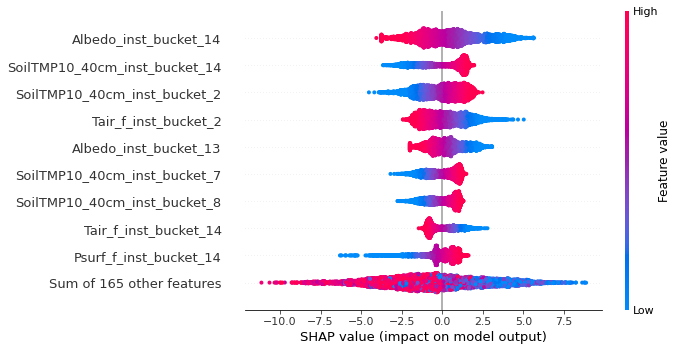

In [11]:
explainer = shap.Explainer(model, train_x_scaled, feature_names=train_x.columns.tolist())
shap_values = explainer(val_x_scaled)
shap.plots.beeswarm(shap_values)